# Data Sampling - Larger Than Memory Files

## 1) Objective
In many cases you will need to load data from a large file. The term "large" refers to the size of the file compared to the memory of your machine and/or to the size of the hard drive. Even if your file is smaller than the memory, loading it might be very slow, if the size of file makes up is a considarable fraction of the memory. While loading data, the allocated fraction of the memory changes during the process and can reach peak values that exceed your memory or get close to its capacity.<br>  
We want to explore a few methods that help us to deal with large files.   

## 2) Preparation

First, we import our standard libraries, such as *pandas* and *numpy*, but also *dask* which is a faster alternative to pandas.<br>
Moreover, we import methods that help us to keep track of the data loading process and a few tools that we are going to need later.

In [ ]:
import os                    # for unix like commands like "listdir" etc
import time                  # measuring time for benchmarking 
import pickle                # for turning data into a more memory efficient .pkl file 
import psutil                # for monitoring cpu and memory ussage 
import functools             # for monitoring cpu and memory ussage 
import tracemalloc           # for monitoring cpu and memory ussage 
import numpy as np
import pandas as pd          
import dask.dataframe as dd  # dask as faster alternative to pandas

In [ ]:
from pyspark.sql import SparkSession     # for exploring larger than memory file
from dask.diagnostics import ProgressBar # for visualizing writing/reading process

Next, we define two *decorators* that help us to measure run time and memory usage:

2a) Standard decorator to monitor current and peak memory consumption

In [ ]:
def memory_usage_decorator(func):
    """Decorator to measure memory usage of a function in MB."""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        result        = func(*args, **kwargs)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        print(f"Memory usage for {func.__name__}:")
        print(f"  Current: {current / (1024 * 1024):.2f} MB")
        print(f"  Peak:    {peak / (1024 * 1024):.2f} MB")
        return result
    return wrapper

2b) Standard decorator to measure runtime:

In [ ]:
def my_timer(my_function):
    def get_args(*args,**kwargs):
        t1      = time.monotonic()
        results = my_function(*args,**kwargs)
        t2      = time.monotonic()
        dt      = t2 - t1
        print("Total runtime: " + str(dt) + ' seconds')
        return results, dt
    return get_args

<br>

## 3) Loading Data Sets

For the purpose of this exercise, we want to load the data set "Data_Set.txt". This data set contains artificially generated data and the actual content is not important for this exercise. Also note, that the size of the file is 182MB, which is way below a standard memory capacity for feasebility. 

**3.1) Standard "pandas"**

The standard way would be loading the file using pandas. Let us see how long that takes and how much memory the process requires: 

In [ ]:
def FindMyFile(filename: str, ServerHardDiscPath: str = r"c:\Users\MMH_user\Desktop") -> str:
    """
    finds file of name "filename" anywhere in "ServerHardDiscPath" and returns complete path
    """
    for r,d,f in os.walk(ServerHardDiscPath):
        for files in f:
             if files == filename: #for example "MessyFile.xlsx"
                 file_name_and_path =  os.path.join(r,files)
                 return file_name_and_path

In [ ]:
Path = FindMyFile('Data_Set.txt')

In [ ]:
print(Path)

In [ ]:
@my_timer
@memory_usage_decorator
def StandardPandas(file_path: str = '../Datasets/Data_Set.txt'):
    return pd.read_csv(file_path)

In [ ]:
out = StandardPandas(Path)

The process should take only a second and the peak memory consumption should be close to the files actual size. 

**3.2) Line by line**

In case of a large file the loading process might take some time. Often, one does not need the entire content, but only some part of the information stored in the file. Therefore, as a first step, it makes sense to read the file line by line for the first, say 5 or 10 lines in order to get an idea of the structure of the file (is it tabular, a messy file etc). For that purpose we can use the method *open*:

In [ ]:
@my_timer
@memory_usage_decorator
def TextFileLineByLine1(file_path: str = '../Datasets/Data_Set.txt', k: int = 5):
    """
    function reads first k lines of data file and prints them
    """
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i>=k:
                break
            print(line)

In [ ]:
TextFileLineByLine1(Path)

As we see, this process is fast and needs almost no memory. We can also see, that the data set is of a clean tabular structure. Thus, we can specificly extract the information we need for our analysis. 

Imagine we only need the data of a specific set of samples. First, we would need to check if the information is stored in the data set in the first place, before loading it (remember: in a real world scenario the size of our file would exceed the memory of your machine!). For that purpose, we can run a keyword search:

In [ ]:
@my_timer
@memory_usage_decorator
def TextFileLineByLine2(file_path: str = '../Datasets/Data_Set.txt',\
                        **keywords):
    """
    function reads lines of data file, searches for keywords and returns 
    location in string
    USAGE: 
    (L, _) = TextFileLineByLine2(word1 = 'time', word2 = 'sample 0', word3 = 'sample 4')
    """
    locations = {v: None for v in keywords.values()}

    with open(file_path, 'r') as file:
        for line in file:
            ListSplit = line.split(',')
            
            for k in locations.keys():
            
                if locations[k] is None and k in ListSplit:
                    locations[k] = ListSplit.index(k)
                
            if all(locations.values()):
                break
    
    #in case some keywords were not found:
    if not all(locations.values()):
        print('the following keywords were not found:\n')
        for k, v in zip(locations.keys(), locations.values()):
            if not v:
                print(k + '\n')
                
    return locations           

In [ ]:
(L, _) = TextFileLineByLine2(Path, word1 = 'time', word2 = 'sample 0', word3 = 'sample 4')

In [ ]:
print(L)

In [ ]:
(L, _) = TextFileLineByLine2(word1 = 'time', word2 = 'sample 0', word3 = 'sample XYZ')

Again, the process is fast and memory efficient. Now, since we know where to look for our data, we can finally import it:

In [ ]:
@my_timer
@memory_usage_decorator
def TextFileLineByLine3(file_path: str = '../Datasets/Data_Set.csv',\
                        **keywords):
    """
    function reads lines of data file, searches for keywords and returns 
    array of data
    USAGE: 
    (L, _) = TextFileLineByLine3(word1 = 'time', word2 = 'sample 0', word3 = 'sample 4')
    Current:  2.44 MB
    Peak:    42.05 MB
    """
    locations = {v: None for v in keywords.values()}

    with open(file_path, 'r') as file:
        for line in file:
            ListSplit = line.split(',')
            
            for k in locations.keys():
            
                if locations[k] is None and k in ListSplit:
                    locations[k] = ListSplit.index(k)
                
            if all(locations.values()):
                break
                
    if not all(locations.values()):
        print('the following keywords were not found:\n')
        for k, v in zip(locations.keys(), locations.values()):
            if not v:
                print(k + '\n')
                
    #now collect the data
    else:
        #list for storing the data
        L = [[] for i in range(len(keywords))] 
        
        with open(file_path, 'r') as file:
            for l, line in enumerate(file):
                
                if l> 1: #header
                    ListSplit = line.split(',')
                
                    for i, (k, v) in enumerate(zip(locations.keys(), locations.values())):
                        L[i].append(ListSplit[v])
                        
    print(L)                    
    A    = np.array(L, dtype = float).T
    A_df = pd.DataFrame(A, columns = locations.keys())
    
    #saving as csv file
    A_df.to_csv('ExtractedData.csv', index = False)
    #saving as pkl file, needs 1/2 times the space
    with open('ExtractedData.pkl', 'wb') as f:
        pickle.dump(A_df, f)
        
    #load via
    #with open(filename, 'rb') as file:
    #    loaded_data = pickle.load(file)
                
    return A_df

In [ ]:
(A_df, _) = TextFileLineByLine3(Path, word1 = 'time', word2 = 'sample 0', word3 = 'sample 4')

In [ ]:
print(A_df.head())

We finally extracted our data! Note, that this process might take much longer and the peak memory consumption might get close to or even exceed the memory capacity for larger files. Thus, we need to explore more alternatives.<bf>
Note, however, that the extracted data was stored as a csv file and as *.pkl* file. A *.pkl* file is a python specific format which is not human readable, but it **needs about half the memory** as a csv file with identical content and the **reading process is a lot faster** (using *pickle.load(file)*). Thus, a *.pkl* file is an efficient way to store structured data, especially if you need to load the data frequently for different workflows.

**3.3) "Dask"** 

Dask reads most common file formats (.csv, .txt) via **parallel processing** which speeds up the process by a factor of 5 - 10 (depending on the number of cpu cores). If the file is larger than your memory, it makes sense to read the data in chunks in order to reduce memory usage.

In [ ]:
@memory_usage_decorator
def Chunks(df):
    return [chunk.compute() for chunk in df.to_delayed()] 

In [ ]:
@my_timer
def CSVFileDask1(file_path: str = '../Datasets/Data_Set.csv',\
                 blocksize: int = 2):
    """
    function reads structured csv file using dask which does parallel
    processing. The data is processed in chunks in order to reduce memory
    usage
    """
                                            #blocksize in MB 
    df = dd.read_csv(file_path, blocksize = int(blocksize * 1024 * 1024))
    
    with ProgressBar():
        #.compute turns the dask object into an actual df
        chunks = Chunks(df)
        
    return pd.concat(chunks, ignore_index = True)

In [ ]:
out = CSVFileDask1(Path, blocksize = 200)

In [ ]:
out = CSVFileDask1(Path, blocksize = 2)

Via the blocksize, we can control how much memory we want to allocate. Note, that **smaller blocksizes require less memory, but segments the data in more chunks and therefore slows down the reading process**. 

In the same way we can read data in chunks, we can also **store the data in chunks**: 

In [ ]:
@memory_usage_decorator
def ChunksSave(df, outfilename: str):

    for i, chunk in enumerate(df.to_delayed()):
        computed_part = chunk.compute()
        
        if i == 0:
            computed_part.to_csv(outfilename, mode = 'w', index = False,\
                                 header = True)
        else:
            computed_part.to_csv(outfilename, mode = 'a', index = False,\
                                 header = False)

In [ ]:
@my_timer
def CSVFileDask2(file_path: str = '../Datasets/Data_Set.csv',\
                 blocksize: int = 2, outfilename: str = 'Out.csv'):
    """
    function reads structured csv file using dask which does parallel
    processing. The data is processed in chunks in order to reduce memory
    usage and also saved to the disc incrementally
    """
                                            #blocksize in MB 
    df = dd.read_csv(file_path, blocksize = int(blocksize * 1024 * 1024))
    
    with ProgressBar():
        #.compute turns the dask object into an actual df
        ChunksSave(df, outfilename)
        
    print('Done!')

In [ ]:
out = CSVFileDask2(Path, blocksize = 200)

In [ ]:
out = CSVFileDask2(Path, blocksize = 2)

We see that we can significantly reduce memory usage, but with the cost of speed, as illustrated in the following diagrams:

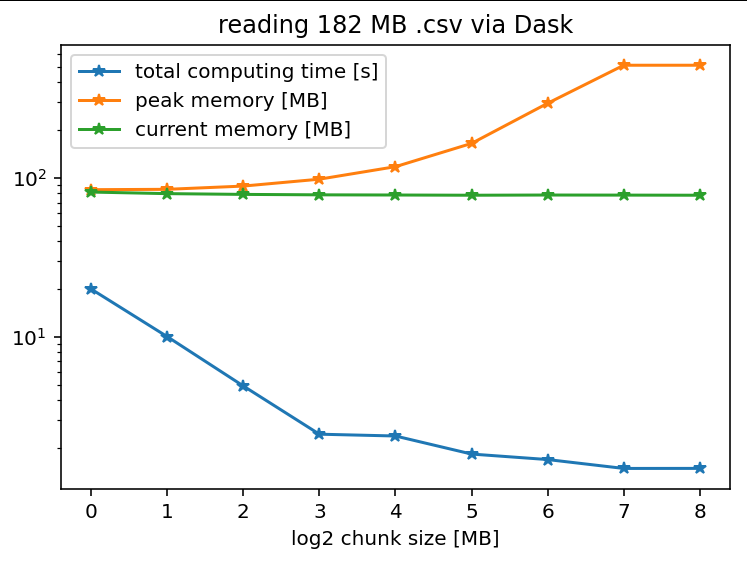
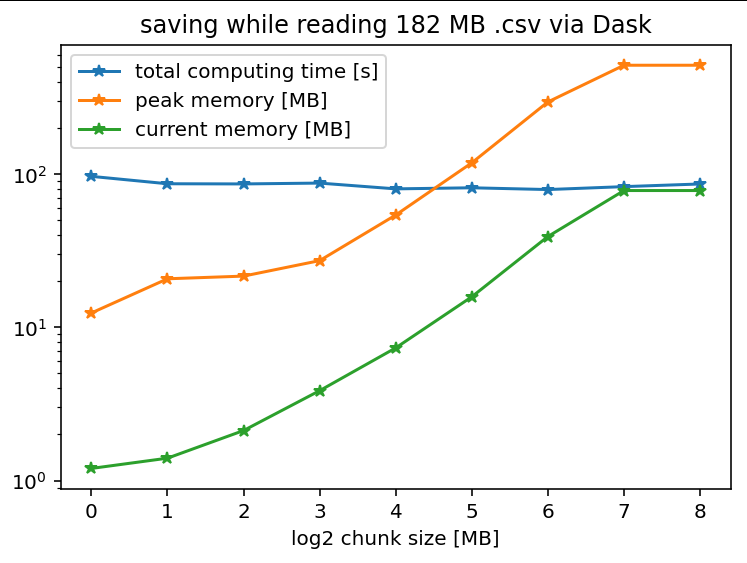

**3.4) "PySpark"**

Another possibility to explore a larger than memory file is using "PySpark". The idea is to first get an overview over the file structure as discussed in 3.1):

In [ ]:
@my_timer
@memory_usage_decorator
def CSVFilePySpark(file_path: str = '../Datasets/Data_Set.csv'):
    """
    Function reads larger than machine's memory file via pyspark
    """
    spark = SparkSession.builder.appName("LargeFileProcessing").getOrCreate()
    df    = spark.read.csv(file_path)
    print(df.head())
    print(df.schema)
    
    return df

In [ ]:
DF = CSVFilePySpark(Path)

In [ ]:
print(DF)